In [43]:
!pip install OWSLib

In [44]:
!pip install lxml

    100% |████████████████████████████████| 5.7MB 7.5MB/s eta 0:00:01    80% |█████████████████████████▋      | 4.5MB 32.1MB/s eta 0:00:01


In [72]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import ipywidgets as widgets
from owslib.wms import WebMapService
import requests
from io import BytesIO
import PIL

def produce_img(wms, layer_name):
    layer = wms[layer_name]
    bbox = layer.boundingBoxWGS84
    img  = wms.getmap(layers = ['0'],
#                 styles = ['visual_bright'],
                 srs = 'EPSG:4326',
                 bbox = bbox,
                 size = (300, 250),
                 format = 'image/jpeg',
                 transparent=True)
    return Image(img.read())


def get_legend(wms, layer_name):
    try:
        layer = wms[layer_name]
        legend_url = layer.styles['default']['legend']
        legend_response = requests.get(legend_url)
        legend_img = PIL.Image.open(BytesIO(legend_response.content))
        return legend_img
    except KeyError:
        return None

see example https://web2.nbmg.unr.edu/ArcGIS/services/CO_Data/COActiveFaults/MapServer/WMSServer?request=GetCapabilities&service=WMS

In [73]:
wms_url = 'https://web2.nbmg.unr.edu/ArcGIS/services/CO_Data/COActiveFaults/MapServer/WMSServer?request=GetCapabilities&service=WMS'

In [74]:
wms = WebMapService(wms_url)

In [75]:
layers = list(wms.contents)
menu = widgets.Dropdown(options = layers)
#the layer's name is called 0, ikr its bad
menu

Dropdown(options=('0',), value='0')

In [76]:
layer_img = produce_img(wms, menu.value)
legend_img = get_legend(wms, menu.value)

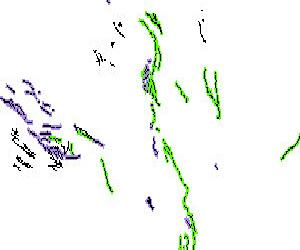

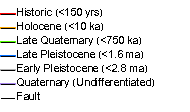

In [77]:
display(layer_img)
display(legend_img)